# 02: Geoprocessing


## imports


In [1]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps


In [2]:
geojson_data = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {"name": "Point 1"},
      "geometry": {
        "coordinates": [-73.96560092061446, 40.8053909556121],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Point 2"},
      "geometry": {
        "coordinates": [-73.9647145298003, 40.80735532167563],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Point 3"},
      "geometry": {
        "coordinates": [-73.96431338989154, 40.80786962173616],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Point 4"},
      "geometry": {
        "coordinates": [-73.96425896894696, 40.80794405546021],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Point 5"},
      "geometry": {
        "coordinates": [-73.98873702621728, 40.7463666340293],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Point 6"},
      "geometry": {
        "coordinates": [-73.98599690307623, 40.74111859750053],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Point 7"},
      "geometry": {
        "coordinates": [-73.9938788366806, 40.741073898023075],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Point 8"},
      "geometry": {
        "coordinates": [-73.99884881239689, 40.744398097162986],
        "type": "Point"
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Point 9"},
      "geometry": {
        "coordinates": [-73.9976773174196, 40.7219124294796],
        "type": "Point"
      }
    }
  ]
}

In [3]:
# Convert GeoJSON data to GeoDataFrame
features = geojson_data["features"]
coords = [feature["geometry"]["coordinates"] for feature in features]
names = [feature["properties"]["name"] for feature in features]
gdf = gpd.GeoDataFrame(
    {"name": names, "geometry": [Point(coord) for coord in coords]},
    crs="EPSG:4326"
)

In [4]:
# Step 1: Load Your Visited Restaurants Data
# Add your visited restaurants data (Example Data)
visited_restaurants_data = {
    "name": ["Visited Restaurant 1", "Visited Restaurant 2", "Visited Restaurant 3"],
    "longitude": [-73.985, -73.986, -73.987],
    "latitude": [40.758, 40.759, 40.760],
}


In [6]:
# Convert to GeoDataFrame
visited_df = pd.DataFrame(visited_restaurants_data)
visited_gdf = gpd.GeoDataFrame(
    visited_df,
    geometry=gpd.points_from_xy(visited_df.longitude, visited_df.latitude),
    crs="EPSG:4326"
)

# Step 2: Fetch Restaurant Cleanliness Data from NYC Open Data
cleanliness_url = "https://data.cityofnewyork.us/resource/43nn-pn8j.json?$limit=5000"
cleanliness_data = requests.get(cleanliness_url).json()

# Step 3: Convert Cleanliness Data to GeoDataFrame
# Filter the cleanliness data to include only entries with both longitude and latitude
filtered_cleanliness_data = [x for x in cleanliness_data if "longitude" in x and "latitude" in x]

# Convert to GeoDataFrame
cleanliness_gdf = gpd.GeoDataFrame(
    filtered_cleanliness_data,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in filtered_cleanliness_data],
        [float(x["latitude"]) for x in filtered_cleanliness_data]
    ),
    crs="EPSG:4326"
)


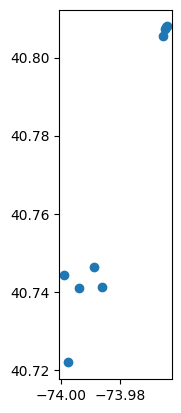

/var/folders/p0/n4n30xss14l6w70vvb2pzcd40000gn/T/ipykernel_57729/1311534340.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(axis=1)[:, 1 : k + 1]


In [7]:
# Step 4: Process Cleanliness Data
# Filter relevant columns and drop duplicates
cleanliness_gdf = cleanliness_gdf[["dba", "grade", "cuisine_description", "geometry"]].drop_duplicates(subset="dba")

# Plot the points
gdf.plot()
plt.show()

# Find five nearest neighbors for each point, not including itself
k = 5
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(axis=1)[:, 1 : k + 1]

# Join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

# Create Line Geometries
def create_lines(r):
    lines = []
    for neighbor in r.neighbors:
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

gdf["line_geometry"] = gdf.apply(create_lines, axis=1)
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)


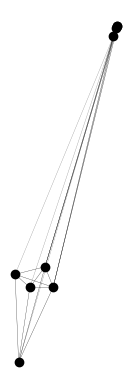

In [8]:
# Plot the lines
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="black").set_axis_off()
plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)
plt.show()


ValueError: aspect must be finite and positive 

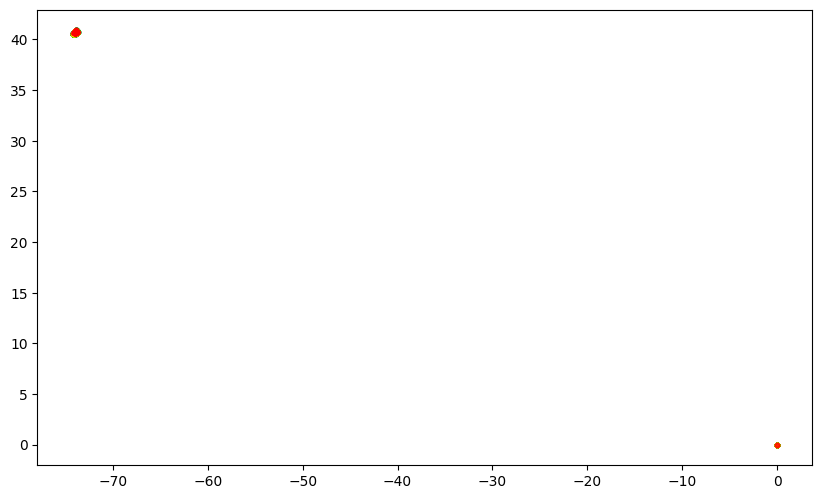

In [10]:
# Plotting Visited Restaurants and Cleanliness Grades
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot cleanliness data with different colors for each grade
grades_colors = {'A': 'green', 'B': 'yellow', 'C': 'red', 'Not Yet Graded': 'gray'}
for grade, color in grades_colors.items():
    cleanliness_gdf[cleanliness_gdf['grade'] == grade].plot(ax=ax, color=color, label=grade, markersize=10, alpha=0.6)


In [13]:
cb_307 = gpd.read_file(
    "../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp"
)


In [14]:
cb_307 = gpd.read_file(
    "../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp"
)
cb_307 = cb_307[cb_307['CD'] == 307]
cb_307.plot()

KeyboardInterrupt: 

In [ ]:
# get maximum bounding geometry for all tax lots
bounds = cb_307.total_bounds

In [ ]:
bounds_poly = gpd.GeoSeries(
    Polygon(
        [
            [bounds[0], bounds[1]],
            [bounds[0], bounds[3]],
            [bounds[2], bounds[3]],
            [bounds[2], bounds[1]],
            [bounds[0], bounds[1]],
        ]
    )
)

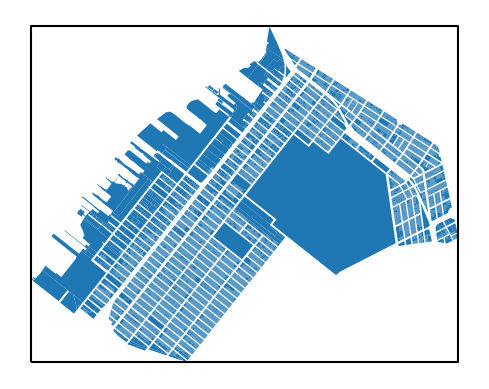

In [ ]:
ax = cb_307.plot()
bounds_poly.boundary.plot(ax=ax, color="black").set_axis_off()

In [ ]:
bounds_poly

0    POLYGON ((975222.902 170552.422, 975222.902 18...
dtype: geometry

In [ ]:
bounds_poly.crs = cb_307.crs

In [ ]:
bounds_poly.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## reproject


In [ ]:
bounds_poly_wgs84 = bounds_poly.to_crs("EPSG:4326")

In [ ]:
cb_307_bldgs = ogr.read_dataframe(
    "../Data/bldg_footprints/Building Footprints.geojson",
    mask=bounds_poly_wgs84[0],
)

<Axes: >

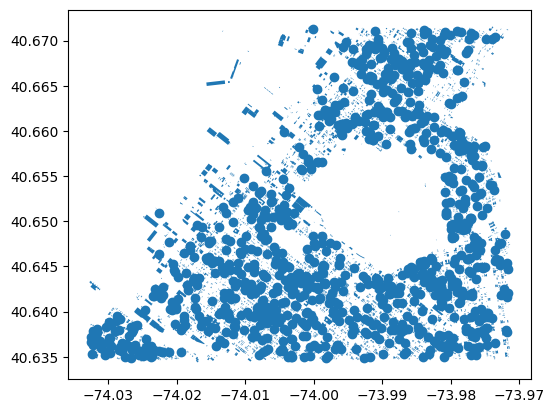

In [ ]:
cb_307_bldgs.plot()

In [ ]:
cb_307_bldgs = cb_307_bldgs[cb_307_bldgs.geometry.type != "Point"]

<Axes: >

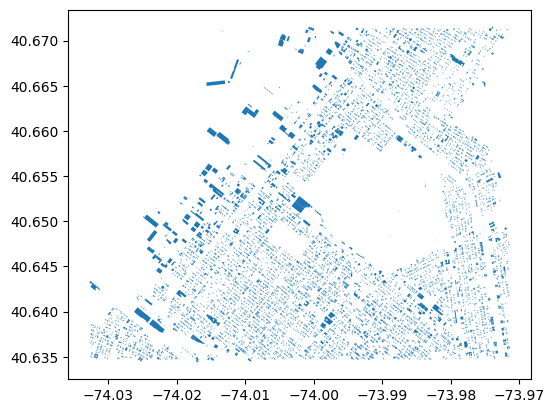

In [ ]:
cb_307_bldgs.plot()

In [ ]:
cb_307_bldgs = cb_307_bldgs.to_crs(cb_307.crs)

## spatial join


In [ ]:
cb_307_bldgs["rep_pt"] = cb_307_bldgs.representative_point()
cb_307_bldgs.set_geometry("rep_pt", inplace=True)

In [ ]:
cb_307_bldgs.base_bbl.nunique(), cb_307_bldgs.shape[0], cb_307_bldgs.globalid.nunique()

(9415, 9959, 9959)

In [ ]:
cb_307_bldgs

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,globalid,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt
0,None,3008130054,0.0,31.05,3008130054,1901,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},Constructed,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.877 174653.879, 979393....",POINT (979402.524 174639.017)
1,None,3010120038,0.0,42.44,3010120038,1921,{65E24ABD-485B-4B01-B70E-5ACA0E221B53},Constructed,2100,115,Photogramm,3022371,2017-08-22,743038,0.0,"MULTIPOLYGON (((989250.108 182249.546, 989226....",POINT (989230.456 182235.371)
2,None,3053130127,0.0,26.38239517,3053130127,1940,{454D03AE-5F41-4886-A5C5-74DD122005EF},Constructed,2100,57,Photogramm,3123939,2017-08-22,785686,0.0,"MULTIPOLYGON (((989342.251 173309.342, 989328....",POINT (989345.272 173326.056)
3,None,3058710090,0.0,24.71,3058710090,1920,{F02017F9-C56E-4793-96D1-03741F2569AC},Constructed,2100,73,Photogramm,3145644,2017-08-22,560761,0.0,"MULTIPOLYGON (((976372.263 170905.535, 976404....",POINT (976382.126 170892.937)
4,None,3058850095,0.0,26.79,3058850095,1925,{D97E7A81-466F-47F7-9159-D52052EC7129},Constructed,2100,68,Photogramm,3146300,2017-08-22,541427,0.0,"MULTIPOLYGON (((975991.819 170852.335, 975985....",POINT (975969.479 170848.979)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9954,None,3011010056,0.0,39.93,3011010056,1890,{D1C7FA9D-ED04-4903-9CBD-1FF326B408ED},Constructed,2100,152,Photogramm,3026556,2020-01-28,145048,0.0,"MULTIPOLYGON (((989777.125 180544.532, 989772....",POINT (989754.879 180526.542)
9955,None,3010760016,0.0,40.55,3010760016,1896,{99EDAE1E-E62A-4B51-9C40-40B83C9973E9},Constructed,2100,96,Photogramm,3025177,2020-01-28,19086,0.0,"MULTIPOLYGON (((990672.233 183829.281, 990666....",POINT (990646.035 183804.579)
9956,None,3010240032,0.0,30.09,3010240032,1901,{125C5EAE-A0F0-467F-B750-E24AFAA72ABF},Constructed,2100,119,Photogramm,3023013,2017-08-22,604181,0.0,"MULTIPOLYGON (((988900.27 181876.491, 988877.7...",POINT (988881.982 181863.224)
9957,None,3058550003,0.0,40.42,3058550003,1957,{BF3925E2-544F-439A-B76D-3EB203698910},Constructed,2100,81,Photogramm,3144699,2017-08-22,239199,0.0,"MULTIPOLYGON (((977966.504 170793.807, 977945....",POINT (977914.923 170803.671)


In [ ]:
gpd.__version__

'1.0.1'

In [ ]:
## spatial join buildings to tax lots based on building representative point
bldgs_w_lot = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin(
    cb_307, how="inner", predicate="within"
)

In [ ]:
bldgs_w_lot_nearest = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin_nearest(
    cb_307, how="left", distance_col="distance"
)

<Axes: >

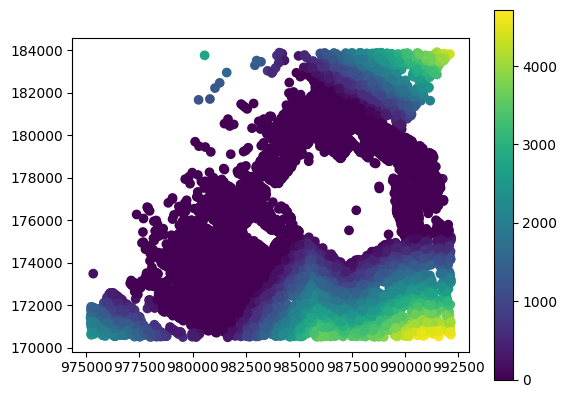

In [ ]:
bldgs_w_lot_nearest.plot("distance", legend=True)

<Axes: >

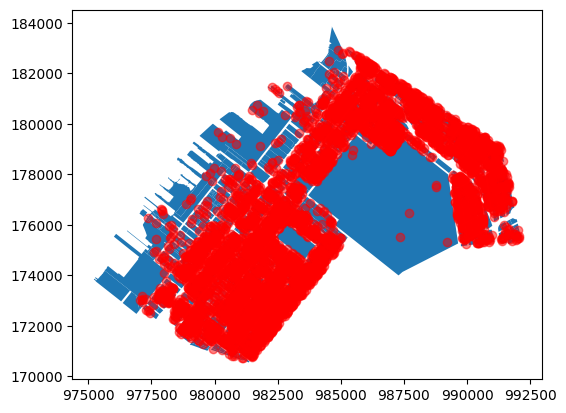

In [ ]:
ax = cb_307.plot()
bldgs_w_lot.plot(ax=ax, color="red", alpha=0.5)

In [ ]:
## drop cases where there is no match (i.e. no tax lot for buildings)

In [ ]:
# now, join back to original building footprints
bldgs_w_lot = bldgs_w_lot.drop(columns=["rep_pt"]).merge(
    cb_307_bldgs, on="globalid", how="left"
)

In [ ]:
bldgs_w_lot_gdf = gpd.GeoDataFrame(bldgs_w_lot, geometry="geometry")

In [ ]:
bldgs_w_lot_gdf.globalid

0       {C2B6150A-AA05-4865-B836-9DFA5C153E9C}
1       {6290F624-6A8D-482F-8BD9-57C27337D89F}
2       {F68D5818-C246-4828-A454-10D28962217D}
3       {441DAB8C-3423-4722-ABDE-4BFE5A472C2B}
4       {B8BC6B19-B2E4-4842-8B03-5C28CC13A572}
                         ...                  
4859    {8E8A2EAD-6916-4C35-A97E-5846CDDEEC7F}
4860    {E6D1BB8D-D5C7-4731-9C97-3ECF233F58B5}
4861    {1271AA7A-A692-4ACB-94B5-C662C13CC17D}
4862    {CA8E5740-AAD2-4C57-9AAD-3CF678CE89C0}
4863    {4BFE9BEC-6381-416A-8099-933D51E36C4B}
Name: globalid, Length: 4864, dtype: object

In [ ]:
bldgs_w_lot_gdf['LandUse'].unique()

array(['01', '08', '06', '04', '05', '02', '07', '10', None, '03', '11',
       '09'], dtype=object)

In [ ]:
bldgs_w_lot_gdf.LandUse

0       01
1       08
2       06
3       04
4       01
        ..
4859    01
4860    01
4861    02
4862    01
4863    01
Name: LandUse, Length: 4864, dtype: object

In [ ]:
print(bldgs_w_lot_gdf['LandUse'].unique())

['01' '08' '06' '04' '05' '02' '07' '10' None '03' '11' '09']


In [ ]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}

In [ ]:
bldgs_w_lot_gdf['LandUse'] = bldgs_w_lot_gdf['LandUse'].map(land_use_codes)

In [ ]:
bldgs_w_lot_gdf['LandUse']

0                     One & Two Family Buildings
1               Public Facilities & Institutions
2                     Industrial & Manufacturing
3       Mixed Residential & Commercial Buildings
4                     One & Two Family Buildings
                          ...                   
4859                  One & Two Family Buildings
4860                  One & Two Family Buildings
4861              Multi-Family Walk-Up Buildings
4862                  One & Two Family Buildings
4863                  One & Two Family Buildings
Name: LandUse, Length: 4864, dtype: object

In [ ]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [ ]:
cmap


{'One & Two Family Buildings': '#ff0000',
 'Multi-Family Walk-Up Buildings': '#00ff00',
 'Multi-Family Elevator Buildings': '#0000ff',
 'Mixed Residential & Commercial Buildings': '#ff00ff',
 'Commercial & Office Buildings': '#00ffff',
 'Industrial & Manufacturing': '#ffff00',
 'Transportation & Utility': '#808080',
 'Public Facilities & Institutions': '#800000',
 'Open Space & Outdoor Recreation': '#008000',
 'Parking Facilities': '#000080',
 'Vacant Land': '#800080',
 'Unknown': '#000000'}

In [ ]:
bldgs_w_lot_gdf["color"] = bldgs_w_lot_gdf["LandUse"].map(cmap)

In [ ]:
bldgs_w_lot_gdf["LandUse"]

0                     One & Two Family Buildings
1               Public Facilities & Institutions
2                     Industrial & Manufacturing
3       Mixed Residential & Commercial Buildings
4                     One & Two Family Buildings
                          ...                   
4859                  One & Two Family Buildings
4860                  One & Two Family Buildings
4861              Multi-Family Walk-Up Buildings
4862                  One & Two Family Buildings
4863                  One & Two Family Buildings
Name: LandUse, Length: 4864, dtype: object

In [ ]:
bldgs_w_lot_gdf["color"]

0       #ff0000
1       #800000
2       #ffff00
3       #ff00ff
4       #ff0000
         ...   
4859    #ff0000
4860    #ff0000
4861    #00ff00
4862    #ff0000
4863    #ff0000
Name: color, Length: 4864, dtype: object

In [ ]:
print(bldgs_w_lot_gdf['LandUse'].unique())

['One & Two Family Buildings' 'Public Facilities & Institutions'
 'Industrial & Manufacturing' 'Mixed Residential & Commercial Buildings'
 'Commercial & Office Buildings' 'Multi-Family Walk-Up Buildings'
 'Transportation & Utility' 'Parking Facilities' nan
 'Multi-Family Elevator Buildings' 'Vacant Land'
 'Open Space & Outdoor Recreation']


In [ ]:
bldgs_w_lot_gdf["LandUse"].fillna("Unknown", inplace=True)

In [ ]:
bldgs_w_lot_gdf.LandUse.unique()

array(['One & Two Family Buildings', 'Public Facilities & Institutions',
       'Industrial & Manufacturing',
       'Mixed Residential & Commercial Buildings',
       'Commercial & Office Buildings', 'Multi-Family Walk-Up Buildings',
       'Transportation & Utility', 'Parking Facilities', 'Unknown',
       'Multi-Family Elevator Buildings', 'Vacant Land',
       'Open Space & Outdoor Recreation'], dtype=object)

In [ ]:
#bldgs_w_lot_gdf = gpd.GeoDataFrame(bldgs_w_lot, geometry="geometry")

In [ ]:
bldgs_w_lot_gdf['color'] #= bldgs_w_lot_gdf['LandUse'].map(cmap)

0       #ff0000
1       #800000
2       #ffff00
3       #ff00ff
4       #ff0000
         ...   
4859    #ff0000
4860    #ff0000
4861    #00ff00
4862    #ff0000
4863    #ff0000
Name: color, Length: 4864, dtype: object

In [ ]:
bldgs_w_lot_gdf

,globalid,mpluto_bbl_x,index_right,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,...,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt,color
0,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},3008130054,320315,BK,813,54,307,3002000,30020002002,20,...,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.877 174653.879, 979393....",POINT (979402.524 174639.017),#ff0000
1,{6290F624-6A8D-482F-8BD9-57C27337D89F},3008370001,129753,BK,837,1,307,3002200,30022002000,22,...,2100,36,Photogramm,3341882,2017-08-22,721766,0.0,"MULTIPOLYGON (((978615.387 174418.93, 978592.1...",POINT (978532.239 174359.992),#800000
2,{F68D5818-C246-4828-A454-10D28962217D},3007890064,128793,BK,789,64,307,3002000,30020001003,20,...,2100,32,Photogramm,3013180,2017-08-22,729838,0.0,"MULTIPOLYGON (((979722.503 175458.546, 979699....",POINT (979672.904 175444.519),#ffff00
3,{441DAB8C-3423-4722-ABDE-4BFE5A472C2B},3052800064,493506,BK,5280,64,307,3050001,30500011001,500,...,2100,62,Photogramm,3122680,2017-08-22,427739,0.0,"MULTIPOLYGON (((989834.115 175442.575, 989851....",POINT (989860.228 175412.76),#ff00ff
4,{B8BC6B19-B2E4-4842-8B03-5C28CC13A572},3011150070,340934,BK,1115,70,307,3017100,30171002000,171,...,2100,147,Photogramm,3027391,2017-08-22,752842,0.0,"MULTIPOLYGON (((990301.644 178978.727, 990272....",POINT (990278.747 178961.571),#ff0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,{8E8A2EAD-6916-4C35-A97E-5846CDDEEC7F},3052810043,493637,BK,5281,43,307,3050001,30500011000,500,...,2100,61,Photogramm,3122715,2017-08-22,713604,0.0,"MULTIPOLYGON (((990162.191 175916.104, 990127....",POINT (990138.47 175923.119),#ff0000
4860,{E6D1BB8D-D5C7-4731-9C97-3ECF233F58B5},3006810018,125995,BK,681,18,307,3010100,30101002004,101,...,2100,26,Photogramm,3340128,2017-08-22,491139,0.0,"MULTIPOLYGON (((983867.634 178256.512, 983849....",POINT (983848.574 178245.275),#ff0000
4861,{1271AA7A-A692-4ACB-94B5-C662C13CC17D},3058080024,165029,BK,5808,24,307,3007200,30072001006,72,...,2100,69,Photogramm,3144046,2017-08-22,77727,0.0,"MULTIPOLYGON (((978390.163 172291.804, 978372....",POINT (978347.983 172264.94),#00ff00
4862,{CA8E5740-AAD2-4C57-9AAD-3CF678CE89C0},3007770033,127525,BK,777,33,307,3010801,30108011000,108,...,2100,125,Photogramm,3012765,2017-08-22,712896,0.0,"MULTIPOLYGON (((983395.142 173328.435, 983360....",POINT (983366.897 173304.341),#ff0000


In [ ]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [ ]:
print(bldgs_w_lot_gdf.columns)

Index(['globalid', 'mpluto_bbl_x', 'index_right', 'Borough', 'Block', 'Lot',
       'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       ...
       'feat_code', 'groundelev', 'geomsource', 'bin', 'lstmoddate',
       'doitt_id', 'shape_len', 'geometry', 'rep_pt', 'color'],
      dtype='object', length=114)


In [ ]:
bldgs_w_lot_gdf

,globalid,mpluto_bbl_x,index_right,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,...,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt,color
0,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},3008130054,320315,BK,813,54,307,3002000,30020002002,20,...,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.877 174653.879, 979393....",POINT (979402.524 174639.017),#ff0000
1,{6290F624-6A8D-482F-8BD9-57C27337D89F},3008370001,129753,BK,837,1,307,3002200,30022002000,22,...,2100,36,Photogramm,3341882,2017-08-22,721766,0.0,"MULTIPOLYGON (((978615.387 174418.93, 978592.1...",POINT (978532.239 174359.992),#800000
2,{F68D5818-C246-4828-A454-10D28962217D},3007890064,128793,BK,789,64,307,3002000,30020001003,20,...,2100,32,Photogramm,3013180,2017-08-22,729838,0.0,"MULTIPOLYGON (((979722.503 175458.546, 979699....",POINT (979672.904 175444.519),#ffff00
3,{441DAB8C-3423-4722-ABDE-4BFE5A472C2B},3052800064,493506,BK,5280,64,307,3050001,30500011001,500,...,2100,62,Photogramm,3122680,2017-08-22,427739,0.0,"MULTIPOLYGON (((989834.115 175442.575, 989851....",POINT (989860.228 175412.76),#ff00ff
4,{B8BC6B19-B2E4-4842-8B03-5C28CC13A572},3011150070,340934,BK,1115,70,307,3017100,30171002000,171,...,2100,147,Photogramm,3027391,2017-08-22,752842,0.0,"MULTIPOLYGON (((990301.644 178978.727, 990272....",POINT (990278.747 178961.571),#ff0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,{8E8A2EAD-6916-4C35-A97E-5846CDDEEC7F},3052810043,493637,BK,5281,43,307,3050001,30500011000,500,...,2100,61,Photogramm,3122715,2017-08-22,713604,0.0,"MULTIPOLYGON (((990162.191 175916.104, 990127....",POINT (990138.47 175923.119),#ff0000
4860,{E6D1BB8D-D5C7-4731-9C97-3ECF233F58B5},3006810018,125995,BK,681,18,307,3010100,30101002004,101,...,2100,26,Photogramm,3340128,2017-08-22,491139,0.0,"MULTIPOLYGON (((983867.634 178256.512, 983849....",POINT (983848.574 178245.275),#ff0000
4861,{1271AA7A-A692-4ACB-94B5-C662C13CC17D},3058080024,165029,BK,5808,24,307,3007200,30072001006,72,...,2100,69,Photogramm,3144046,2017-08-22,77727,0.0,"MULTIPOLYGON (((978390.163 172291.804, 978372....",POINT (978347.983 172264.94),#00ff00
4862,{CA8E5740-AAD2-4C57-9AAD-3CF678CE89C0},3007770033,127525,BK,777,33,307,3010801,30108011000,108,...,2100,125,Photogramm,3012765,2017-08-22,712896,0.0,"MULTIPOLYGON (((983395.142 173328.435, 983360....",POINT (983366.897 173304.341),#ff0000


In [ ]:
bldgs_w_lot_gdf.LandUse.unique()

array(['One & Two Family Buildings', 'Public Facilities & Institutions',
       'Industrial & Manufacturing',
       'Mixed Residential & Commercial Buildings',
       'Commercial & Office Buildings', 'Multi-Family Walk-Up Buildings',
       'Transportation & Utility', 'Parking Facilities', 'Unknown',
       'Multi-Family Elevator Buildings', 'Vacant Land',
       'Open Space & Outdoor Recreation'], dtype=object)

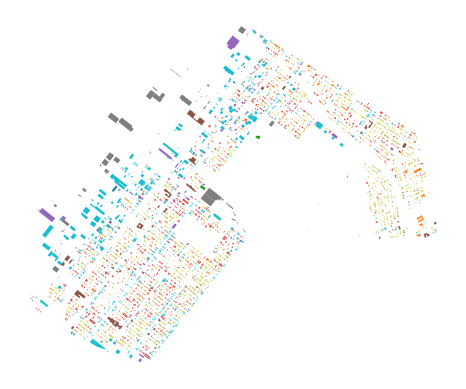

In [ ]:
bldgs_w_lot_gdf.plot(column="color", legend=False).set_axis_off()


In [ ]:
bldgs_w_lot_gdf.fillna({"LandUse": "Unknown"}, inplace=True)

In [ ]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [ ]:
bldgs_w_lot_gdf.columns

Index(['globalid', 'mpluto_bbl_x', 'index_right', 'Borough', 'Block', 'Lot',
       'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       ...
       'feat_code', 'groundelev', 'geomsource', 'bin', 'lstmoddate',
       'doitt_id', 'shape_len', 'geometry', 'rep_pt', 'color'],
      dtype='object', length=114)

In [ ]:
# make a lonboard plot with color based on land use and height based on number of floors
heights = bldgs_w_lot_gdf["heightroof"].astype(float).to_numpy()
bldgs_layer = PolygonLayer.from_geopandas(
    bldgs_w_lot_gdf[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(bldgs_w_lot_gdf["LandUse"], cmap=cmap_rgb),
    extruded=True,
    get_elevation=heights,
)

m = Map(
    [bldgs_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

/Users/badriyah/Documents/GitHub/cdp-mapping-systems/myenv/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x3d3bc85e0>
[
  31.05…

## attribute join


... sometimes it makes more sense to join based on attributes rather than spatial relationships. This is one of those cases.


In [ ]:
cb_307_bldgs.mpluto_bbl.nunique(), cb_307.shape

(9413, (13284, 95))

In [ ]:
cb_307.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [ ]:
cb_307_bldgs.mpluto_bbl.dtype, cb_307.BBL.dtype

(dtype('O'), dtype('float64'))

In [ ]:
cb_307_bldgs["mpluto_bbl"] = cb_307_bldgs["mpluto_bbl"].astype(float)

In [ ]:
bldgs_w_lot_attrib = cb_307_bldgs.merge(
    cb_307, left_on="mpluto_bbl", right_on="BBL", how="inner"
)

In [ ]:
# assert bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape
bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape

False

In [ ]:
bldgs_w_lot_gdf.globalid

0       {C2B6150A-AA05-4865-B836-9DFA5C153E9C}
1       {6290F624-6A8D-482F-8BD9-57C27337D89F}
2       {F68D5818-C246-4828-A454-10D28962217D}
3       {441DAB8C-3423-4722-ABDE-4BFE5A472C2B}
4       {B8BC6B19-B2E4-4842-8B03-5C28CC13A572}
                         ...                  
4859    {8E8A2EAD-6916-4C35-A97E-5846CDDEEC7F}
4860    {E6D1BB8D-D5C7-4731-9C97-3ECF233F58B5}
4861    {1271AA7A-A692-4ACB-94B5-C662C13CC17D}
4862    {CA8E5740-AAD2-4C57-9AAD-3CF678CE89C0}
4863    {4BFE9BEC-6381-416A-8099-933D51E36C4B}
Name: globalid, Length: 4864, dtype: object

<Axes: >

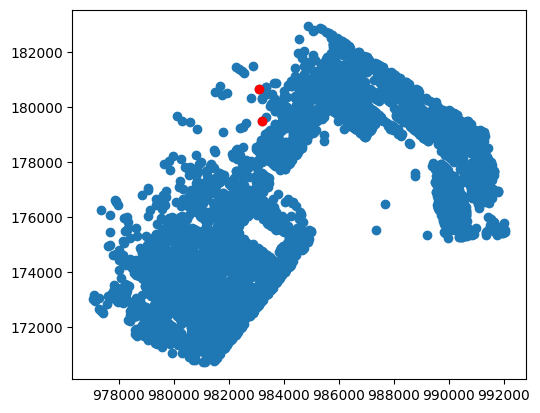

In [ ]:
# find the globalid of the buildings in bldgs_w_lot_attrib that are not in bldgs_w_lot_gdf
ax = bldgs_w_lot_attrib.plot()
bldgs_w_lot_attrib[~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)].plot(
    ax=ax, color="red"
)

In [ ]:
#bldgs_w_lot_attrib.globalid#.isin(bldgs_w_lot_gdf.globalid)
bldgs_w_lot_gdf.globalid

0       {C2B6150A-AA05-4865-B836-9DFA5C153E9C}
1       {6290F624-6A8D-482F-8BD9-57C27337D89F}
2       {F68D5818-C246-4828-A454-10D28962217D}
3       {441DAB8C-3423-4722-ABDE-4BFE5A472C2B}
4       {B8BC6B19-B2E4-4842-8B03-5C28CC13A572}
                         ...                  
4859    {8E8A2EAD-6916-4C35-A97E-5846CDDEEC7F}
4860    {E6D1BB8D-D5C7-4731-9C97-3ECF233F58B5}
4861    {1271AA7A-A692-4ACB-94B5-C662C13CC17D}
4862    {CA8E5740-AAD2-4C57-9AAD-3CF678CE89C0}
4863    {4BFE9BEC-6381-416A-8099-933D51E36C4B}
Name: globalid, Length: 4864, dtype: object

In [ ]:
missing_buildings = bldgs_w_lot_attrib[
    ~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)
].globalid.unique()

In [ ]:
bldgs_w_lot_attrib["geometry"] = bldgs_w_lot_attrib["geometry_x"]

In [ ]:
bldgs_w_lot_attrib.set_geometry("geometry", inplace=True)

In [ ]:
bldgs_w_lot_attrib.head(3)

NameError: name 'bldgs_w_lot_attrib' is not defined

### investigate- what's going on??


In [ ]:
# for cb`_307`
# first, map `landuse` using land`-use``-codes`

cb_307.plot()
# then map `color` using `cmap_rgb`
# 
# go from landuse```; 01 to landuse `; one and story family buildings
# color`; hex codes` 

NameError: name 'cb_307' is not defined

In [ ]:
# make a lonboard plot with color based on land use and height based on number of floors

missing_bldgs = bldgs_w_lot_attrib[bldgs_w_lot_attrib.globalid.isin(missing_buildings)]

heights_missing = missing_bldgs["heightroof"].astype(float).to_numpy()

lots_layer = PolygonLayer.from_geopandas(
    cb_307[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(cb_307["LandUse"], cmap=cmap_rgb),
)

missing_bldgs_layer = PolygonLayer.from_geopandas(
    missing_bldgs[["geometry", "LandUse"]],
    get_fill_color=[255, 0, 0, 155],
    extruded=True,
    get_elevation=heights_missing,
)

m = Map(
    [missing_bldgs_layer, lots_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

NameError: name 'bldgs_w_lot_attrib' is not defined

So we can see that there are three cases where buildings are associated with lots, even if their representative point (or entire geometry) fall outside of the actual polygon.


## dissolve


Learn more about dissolve here: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html


In [ ]:
cb_307

In [ ]:
cb_307_by_owner = cb_307.dissolve(
    by="OwnerName",
    aggfunc={
        "LandUse": list,
        "LotArea": "sum",
    },
).reset_index()

In [ ]:
fig, ax = plt.subplots()
cb_307.plot(color="#cecece", ax=ax, alpha=0.5)

cb_307_by_owner.sort_values("LotArea", ascending=False).head(10).plot(
    column="OwnerName", legend=True, ax=ax
).set_axis_off()


# get legend item
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.0, 0.5, 0.2))
ax.set_title("Top 10 Owners by Lot Area")
# put legend off the plot
# cb_307_by_owner.plot(column="OwnerName", legend=False)

In [ ]:
cb_307_by_owner

## Intersect / Difference


In [ ]:
sample_block = cb_307.Block.sample(1).values[0]

In [ ]:
sample_block

In [ ]:
cb_307_bldgs.columns

In [ ]:
sample_block_lots = cb_307[cb_307.Block.eq(sample_block)].copy()
sample_block_bldgs = cb_307_bldgs[
    cb_307_bldgs.mpluto_bbl.isin(sample_block_lots.BBL.unique())
].copy()

In [ ]:
sample_block_bldgs.set_geometry("geometry", inplace=True)

In [ ]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_bldgs.plot(ax=ax, color="red").set_axis_off()

ax.set_title(f"Block {sample_block}")

In [ ]:
sample_block_non_bldg = sample_block_lots.difference(sample_block_bldgs.unary_union)

In [ ]:
sample_block_non_bldg.shape

In [ ]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_non_bldg.plot(ax=ax)
sample_block_bldgs.plot(ax=ax, color="orange").set_axis_off()

In [ ]:
sample_block_non_bldg_intersect = sample_block_lots.intersection(
    sample_block_bldgs.unary_union
)

In [ ]:
sample_block_non_bldg_intersect.shape

In [ ]:
sample_block_non_bldg_intersect.plot()

## Union


In [ ]:
sample_block_lots["lot_area"] = sample_block_lots.area

NameError: name 'sample_block_lots' is not defined

In [ ]:
lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")

In [ ]:
lots_bldgs_union.shape

In [ ]:
import pandas as pd

In [ ]:
lots_bldgs_union

In [ ]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot(color="#cecece")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot(ax=ax, color="red")

In [ ]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot("Lot")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot("Lot", ax=ax)
lots_bldgs_union.boundary.plot(color="black", ax=ax, linewidth=0.5).set_axis_off()

In [ ]:
lots_bldgs_union.globalid.unique()

In [ ]:
lots_bldgs_union["pct_bldg_lot_coverage"] = lots_bldgs_union.apply(
    lambda x: ((x.geometry.area / x.lot_area) * 100 if type(x.globalid) == str else -1),
    axis=1,
)

In [ ]:
lots_bldgs_union.plot("pct_bldg_lot_coverage", legend=True)

## calculate soft sites (create new attributes)


In [ ]:
def is_soft_site(r, threshold=0.33):
    if (
        r.BuiltFAR <= r.ResidFAR * threshold
        and r.LotArea > 10000
        and r.LandUse != "Open Space & Outdoor Recreation"
        and r.ResidFAR > 0
    ):
        return 1
    else:
        return 0

In [ ]:
cb_307["soft_site"] = cb_307.apply(is_soft_site, axis=1)

NameError: name 'cb_307' is not defined

In [ ]:
cb_307["soft_site"].value_counts()

NameError: name 'cb_307' is not defined

In [ ]:
cb_307.plot("soft_site", legend=True)

NameError: name 'cb_307' is not defined

In [ ]:
cb_307[cb_307.soft_site.eq(1)][["soft_site", "BuiltFAR", "ResidFAR"]]

NameError: name 'cb_307' is not defined